In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from flash_attn import flash_attn_func

from library import StockUniverse, FactorLibrary, MarketInfo, FileLoader





class MarketGuidedGating(nn.Module):
    def __init__(self, market_dim, feature_dim, beta=5):
        super().__init__()
        self.fc = nn.Linear(market_dim, feature_dim)
        nn.init.xavier_uniform_(self.fc.weight)  # 加這行
        nn.init.zeros_(self.fc.bias)             # 初始化 bias 為 0
        self.beta = beta
        self.feature_dim = feature_dim

    def forward(self, x, m):
        alpha = self.feature_dim * F.softmax(self.fc(m) / self.beta, dim=-1)
        #print("fc weight max:", self.fc.weight.max().item(), "min:", self.fc.weight.min().item())
        #print(self.fc(m))
        #print(m.max(), m.min())
        #print(torch.isnan(m.any()))
        #print(torch.isnan(self.fc(m)).any())
        
        #print(F.softmax(self.fc(m) / self.beta, dim=-1).sum(axis=1))
        #print(alpha.shape)
        #print(f'alpha : {alpha}')
        
        return x * alpha  # Hadamard product

class IntraStockEncoder(nn.Module):
    def __init__(self, feature_dim, embed_dim=256, nhead=4, max_len=60):
        super().__init__()
        self.input_proj = nn.Linear(feature_dim, embed_dim)#
        self.register_buffer('pos_encoder', self._get_sinusoid_encoding_table(max_len, embed_dim))#
        self.encoder_norm = nn.LayerNorm(embed_dim)#
        
        self.embed_dim = embed_dim#
        self.nhead = nhead#
        self.head_dim = embed_dim // nhead#
        assert self.head_dim * nhead == embed_dim, "embed_dim must be divisible by nhead"#
        
        
        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim) #
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Linear(4 * embed_dim, embed_dim),
        )

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        

    def forward(self, x):
        batch, time, _ = x.shape#
        x = self.input_proj(x)#
        #print(f'x.shape : {x.shape}')
        x = x + self.pos_encoder[:time, :].unsqueeze(0)#
        x = self.encoder_norm(x)#

        # QKV projection
        qkv = self.qkv_proj(x)  # (batch, time, 3*embed_dim) #
        qkv = qkv.view(batch, time, 3, self.nhead, self.head_dim) #
        q, k, v = qkv.unbind(dim=2)  # (batch, time, nhead, head_dim) #

        # Flash Attention
        attn_out = flash_attn_func(q, k, v, dropout_p=0.0, causal=False)  # (batch, time, nhead, head_dim)#
        attn_out = attn_out.view(batch, time, self.embed_dim)

        # Residual + Norm
        x = self.norm1(attn_out + x)

        # Feed Forward
        ffn_out = self.ffn(x)
        out = self.norm2(ffn_out + x)  # 注意這裡是再次 residual+norm

        return out

    def _get_sinusoid_encoding_table(self, seq_len, d_model):
        position = torch.arange(seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

class InterStockAggregator(nn.Module):
    def __init__(self, embed_dim=256, nhead=2):
        super().__init__()
        self.embed_dim = embed_dim
        self.nhead = nhead
        self.head_dim = embed_dim // nhead
        assert self.head_dim * nhead == embed_dim, "embed_dim must be divisible by nhead"

        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.ReLU(),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        batch, stocks, time, embed_dim = x.shape#

        x_reshaped = x.permute(0, 2, 1, 3).reshape(batch * time, stocks, embed_dim)#

        qkv = self.qkv_proj(x_reshaped)
        qkv = qkv.view(batch * time, stocks, 3, self.nhead, self.head_dim)
        q, k, v = qkv.unbind(dim=2)

        attn_out = flash_attn_func(q, k, v, dropout_p=0.0, causal=False)
        attn_out = attn_out.reshape(batch * time, stocks, embed_dim)

        x_attn = self.norm1(attn_out + x_reshaped)
        ffn_out = self.ffn(x_attn)
        out = self.norm2(ffn_out + x_attn)

        out = out.view(batch, time, stocks, embed_dim).permute(0, 2, 1, 3)

        return out

class TemporalAggregator(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.w_lambda = nn.Parameter(torch.randn(embed_dim, embed_dim))

    def forward(self, x):
        query = x[:, :, -1, :]
        scores = torch.einsum('bstf,fd,bsd->bst', x, self.w_lambda, query)
        weights = F.softmax(scores, dim=2) 
        output = torch.einsum('bst,bstf->bsf', weights, x)
        return output


#def __init__(self, market_dim, feature_dim, embed_dim=256, nhead1=4, nhead2=2, beta=5):
class MASTER(nn.Module):
    def __init__(self, market_dim, feature_dim, embed_dim=256, nhead1=4, nhead2=2, beta=5):
        super().__init__()
        self.gating = MarketGuidedGating(market_dim, feature_dim, beta)
        self.intra_encoder = IntraStockEncoder(feature_dim, embed_dim, nhead1)
        self.inter_agg = InterStockAggregator(embed_dim, nhead2)
        self.temporal_agg = TemporalAggregator(embed_dim)
        self.predictor = nn.Linear(embed_dim, 1)

    def forward(self, x, market):
        batch, stocks, time, features = x.shape

        market_expanded = market[:, None, None, :].expand(-1, stocks, time, -1)

        #print(f'market_expanded : {torch.isnan(market_expanded).any()}')
        market_scaled = self.gating(x, market_expanded)
        
        #print(f'market_scaled : {market_scaled}')
        #if torch.isnan(market_scaled).any():
        #    print("⚠️ market_scaled 含 NaN")

        x_flat = market_scaled.view(batch * stocks, time, features)
        local_embed = self.intra_encoder(x_flat)
        
        #print(f'intra_encoder : {local_embed}')
        
        local_embed = local_embed.view(batch, stocks, time, -1)

        inter_embed = self.inter_agg(local_embed)
        temporal_embed = self.temporal_agg(inter_embed)
        out = self.predictor(temporal_embed).squeeze(-1)
        #print("fc weight max:", model.gating.fc.weight.max().item(), "min:", model.gating.fc.weight.min().item())
        #print(f'torch.isnan(out).any() : {torch.isnan(out).any()}')
        #print(f'out : {out}')

        return out


📂 讀取: Y:\因子回測_江建彰\因子庫.pkl


In [10]:
import pandas as pd
from torch.utils.data import Dataset
import numpy as np
import gc
import torch
from torch.utils.data import DataLoader

In [13]:
class AllDayFactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE'):
        self.multi_df = FileLoader.load(f'Y:\因子回測_江建彰\因子庫{stock_universe}.pkl')
        self.adj_close_df = pd.read_feather(r'Y:\因子回測_江建彰\補上缺值日頻收盤價.ftr')
        self.stock_list = self.get_stock_list(stock_universe)
        
        self.TPEX_df = MarketInfo.TPEX_norm()
        self.RoR_df = (self.adj_close_df.shift(-5) - self.adj_close_df.shift(-1)) / self.adj_close_df.shift(-1)
        self.RoR_df.dropna(axis=0, inplace=True)


        new_ticker_list = self.multi_df.columns.get_level_values('ticker')
        new_ticker_list = new_ticker_list[~new_ticker_list.duplicated()]

        self.stock_list = new_ticker_list
        self.RoR_df = self.RoR_df[self.stock_list]
        # 這裡所有值都包含當天資訊所以要向後移
        self.restrict_range()
        self.check_validility()

        


        

        #self.tensor_factor = self.factor_to_tensor()
        #self.tensor_market = self.TPEX_df.values
        #self.tensor_return = self.RoR_df[self.stock_list]
        #print(f'stock list : {len(self.stock_list)}')
    def check_validility(self):
        ticker_list1 = self.stock_list
        ticker_list2 = self.RoR_df.columns
        ticker_list3 = self.multi_df.columns.get_level_values('ticker')
        ticker_list3 = ticker_list3[~ticker_list3.duplicated()]
        assert len(ticker_list1)==len(ticker_list2)==len(ticker_list3)
        
        BOOL = True
        for i in range(len(ticker_list1)):
            if not (ticker_list1[i]==ticker_list2[i]==ticker_list3[i]):
                BOOL = False
        assert BOOL==True
        

        factor_list = self.multi_df.columns.get_level_values('factor')
        factor_list = factor_list[~factor_list.duplicated()]
        BOOL = True
        for factor_name in factor_list:
            ticker_list4 = self.multi_df.loc[ : , factor_name].columns
            for i in range(len(ticker_list1)):
                if ticker_list1[i]!=ticker_list4[i]:
                    BOOL = False
        assert BOOL==True
        

    def factor_to_tensor(self):
        factor_num = len(self.multi_df.columns.get_level_values('factor').unique())
        time = len(self.TPEX_df.index)
        

       
            
            
                
        """
        剔除因子缺失太多的股票
        
        new_stock_list = []
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = self.multi_df.xs(ticker, axis=1, level='ticker').values
            missing_ratio = np.isnan(numpy_array).sum() / (time*factor_num)
            if(missing_ratio<=0.05):
                new_stock_list.append(ticker)
        self.stock_list = new_stock_list
        """

        """
        轉成向量
        """

        
        factor_name = 'factor1'
        #print(self.multi_df.loc[start_date : end_date, factor_name])

        
        stock_num = len(self.stock_list)
        tensor_factor = np.empty((stock_num, time, factor_num))
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = self.multi_df.xs(ticker, axis=1, level='ticker').ffill().values
            numpy_array = np.nan_to_num(numpy_array, nan=0.0)
            tensor_factor[idx] = numpy_array

        
        
        return tensor_factor

    

    def restrict_range(self, global_start='2020-04-01', global_end='2025-04-09'):
        self.multi_df     = self.multi_df.loc[global_start : global_end]
        self.adj_close_df = self.adj_close_df.loc[global_start : global_end]
        self.TPEX_df      = self.TPEX_df.loc[global_start : global_end]
        self.RoR_df       = self.RoR_df.loc[global_start : global_end]
    
        
        
        
    def get_stock_list(self, stock_univserse):
        if stock_univserse=='TWSE':
            ticker1 = StockUniverse.TWSE() 
        elif stock_univserse=='OTC':
            ticker1 = StockUniverse.OTC()
        elif stock_univserse=='all':
            ticker1 = StockUniverse.all()
            
        
        ticker2 = self.multi_df.columns.get_level_values('ticker')
        ticker3 = self.adj_close_df.columns
        return list(set(ticker1)&set(ticker2)&set(ticker3))


    

In [34]:
class FactorDataset(Dataset):
    def __init__(self, stock_universe='TWSE', mode='train'):
        #multi_df, TPEX_df, RoR_df = self.restrict_data_range(stock_universe, mode)
        self.e = AllDayFactorDataset(stock_universe='TWSE')
        self.stock_list = self.e.stock_list
        multi_df, TPEX_df, RoR_df = self.restrict_data_range(stock_universe, mode)

        
        
        self.tensor_factor = self.get_tensor_factors(multi_df)
        #self.tesnor_factor = self.tesnor_factor.transpose(1,0,2) # (stock, time, factor) -> (time, stock, factor)
        self.tensor_market = TPEX_df.values
        self.tensor_return = RoR_df.values

        self.tensor_factor = self.transform_to_tensor(self.tensor_factor)
        self.tensor_market = self.transform_to_tensor(self.tensor_market)
        self.tensor_return = self.transform_to_tensor(self.tensor_return)




        returns = self.tensor_return.clone()  # shape: [122, 887]
        mean = returns.mean(dim=1, keepdim=True)   # 每天的均值 shape: [122, 1]
        std = returns.std(dim=1, keepdim=True)     # 每天的標準差 shape: [122, 1]
        # 防止除以 0
        std = torch.where(std == 0, torch.tensor(1.0), std)
        self.tensor_return_norm = (returns - mean) / std  # shape: [122, 887]


        self.T = self.tensor_market.shape[0]
        self.lookback = 8
        self.valid_length = self.T - self.lookback

        del self.e
        gc.collect()

        self.TPEX_df = TPEX_df
        
    def transform_to_tensor(self, numpy_array):
        float32_np = numpy_array.astype(np.float32)
        return torch.from_numpy(float32_np)

    def get_tensor_factors(self, multi_df):
        stock_num = len(multi_df.columns.get_level_values('ticker').unique())
        time = len(multi_df.index)
        factor_num = len(multi_df.columns.get_level_values('factor').unique())
        
        tensor_factor = np.empty((stock_num, time, factor_num))
        for idx, ticker in enumerate(self.stock_list):
            numpy_array = multi_df.xs(ticker, axis=1, level='ticker').values
            tensor_factor[idx] = numpy_array

        assert not np.isnan(tensor_factor).any()

        return tensor_factor
        

    def restrict_data_range(self, stock_universe, mode):
        e = AllDayFactorDataset(stock_universe)
        train_ratio, valid_ratio, test_ratio = 0.8, 0.1, 0.1
        total_num = len(self.e.TPEX_df)
        train_num = int(total_num*train_ratio)
        valid_num = int(total_num*valid_ratio)
        test_num  = total_num - (train_num+valid_num)
        if mode=='train':
            start_idx, end_idx = 0, train_num
        elif mode=='valid':
            start_idx, end_idx = train_num, train_num + valid_num
        elif mode=='test': 
            start_idx, end_idx = train_num + valid_num, total_num

        e = AllDayFactorDataset(stock_universe)
        return self.e.multi_df.iloc[start_idx : end_idx], \
               self.e.TPEX_df.iloc[start_idx : end_idx], \
               self.e.RoR_df.iloc[start_idx : end_idx]
    def __len__(self):
        return self.valid_length
        
    def __getitem__(self, idx):
        X = self.tensor_factor[ : , idx:idx+self.lookback, : ] # (stock, time, factor)
        M = self.tensor_market[idx+self.lookback-1, : ]
        R = self.tensor_return[idx+self.lookback-1, : ]
        R_norm = self.tensor_return_norm[idx+self.lookback-1, : ]
        return X, M, R, R_norm
        

#t = FactorDataset(stock_universe='TWSE', mode='train')

In [35]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
test_set = FactorDataset(stock_universe='TWSE', mode='test')

⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl
⚡ 快取使用: Y:\因子回測_江建彰\因子庫TWSE.pkl


In [58]:
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

model = MASTER(market_dim=21, feature_dim=186, embed_dim=256, nhead1=4, nhead2=2, beta=2).to(device)
state_dict = torch.load("MASTER_best_model.pt", weights_only=True)
model.load_state_dict(state_dict)

model.eval()  # 設定為評估模式（關閉 dropout、batchnorm）

factors, market, returns = test_set.tensor_factor, test_set.tensor_market, test_set.tensor_return
factors, market = factors.to(device), market.to(device)

lookback = 8
valid_length = len(market) - lookback



cum = 1
long_cum = 1
short_cum = 1

cum_list = []
long_cum_list = []
short_cum_list = []


with torch.no_grad():
    for idx in range(valid_length):
        X = factors[ : , idx:idx+lookback, : ] # (stock, time, factor)
        M = market[idx+lookback-1, : ]

        X = X.unsqueeze(0) # (batch=1, stock, time, factor)
        M = M.unsqueeze(0) # (batch=1, feature)
        ret = returns[idx+lookback-1, : ]
        #print(X.shape, M.shape, ret.shape)
        
        
        with autocast('cuda', dtype=torch.float16):
            logits = model(X, M)
            logits = logits.squeeze()
            logits = logits.cpu()
            #print(logits.shape)
        top_indices = torch.topk(logits, 30, largest=True).indices
        bottom_indices = torch.topk(logits, 30, largest=False).indices

        long = ret[top_indices]
        short = ret[bottom_indices]
        combined = torch.cat([long, -short], dim=0)  # shape: [60]


        cum = cum + torch.mean(combined).item()
        long_cum = long_cum + torch.mean(long).item()
        short_cum = short_cum + torch.mean(-short).item()

        
        cum_list.append(cum)
        long_cum_list.append(long_cum)
        short_cum_list.append(short_cum)
        
        



   


In [59]:
len(test_set.TPEX_df.index[8:])

114

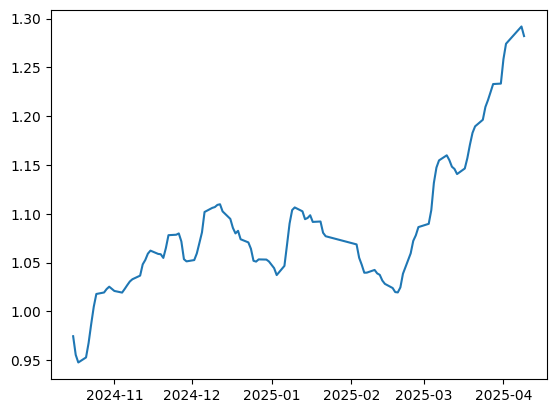

In [60]:
plt.plot(test_set.TPEX_df.index[8:], cum_list)

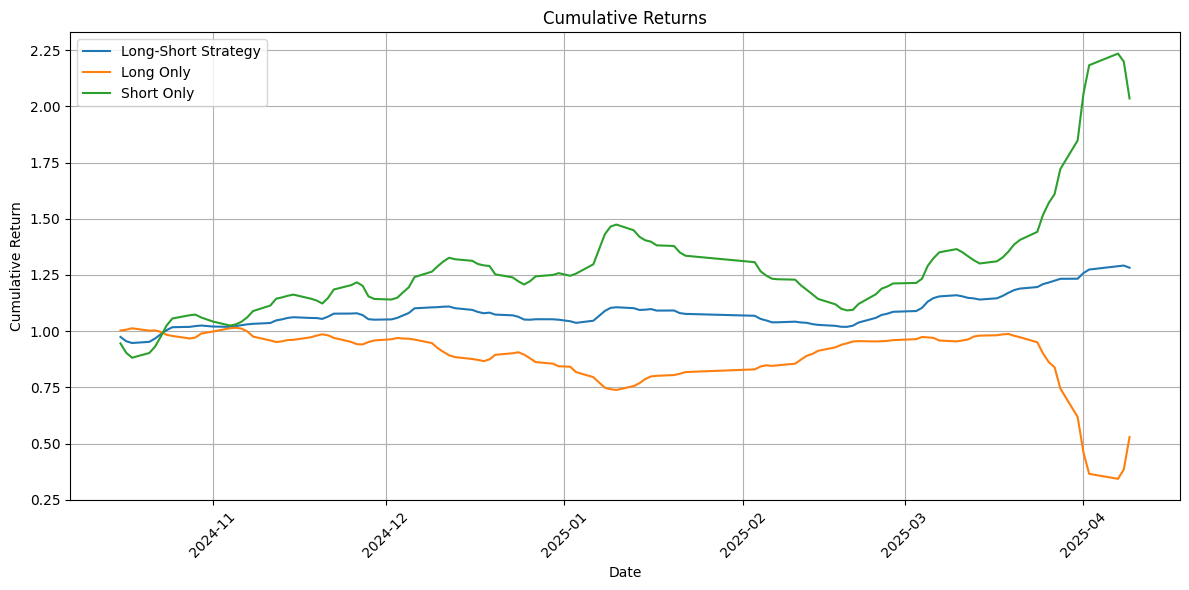

In [61]:
import matplotlib.pyplot as plt

dates = test_set.TPEX_df.index[8:]  # 對應 lookback=8 之後的日期

plt.figure(figsize=(12, 6))
plt.plot(dates, cum_list, label='Long-Short Strategy')
plt.plot(dates, long_cum_list, label='Long Only')
plt.plot(dates, short_cum_list, label='Short Only')

plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [68]:
import torch
import numpy as np

num_quantiles = 10
quantile_cum_returns = [1.0 for _ in range(num_quantiles)]
quantile_cum_list = [[] for _ in range(num_quantiles)]

with torch.no_grad():
    for idx in range(valid_length):
        X = factors[:, idx:idx+lookback, :]
        M = market[idx+lookback-1, :]
        ret = returns[idx+lookback-1, :]

        X = X.unsqueeze(0)
        M = M.unsqueeze(0)

        with autocast('cuda', dtype=torch.float16):
            logits = model(X, M).squeeze().cpu()  # 模型打分 (N,)
        
        # 分數排序，取得每一層的 index
        scores_np = logits.numpy()
        sorted_indices = np.argsort(scores_np)
        total_stocks = len(scores_np)
        stocks_per_quantile = total_stocks // num_quantiles

        for q in range(num_quantiles):
            start = q * stocks_per_quantile
            end = (q + 1) * stocks_per_quantile if q != num_quantiles - 1 else total_stocks
            quantile_indices = sorted_indices[start:end]

            # 計算該 quantile 當天平均報酬
            q_ret = ret[quantile_indices]
            avg_q_ret = q_ret.mean().item()

            # 更新累積報酬
            quantile_cum_returns[q] += avg_q_ret
            quantile_cum_list[q].append(quantile_cum_returns[q])


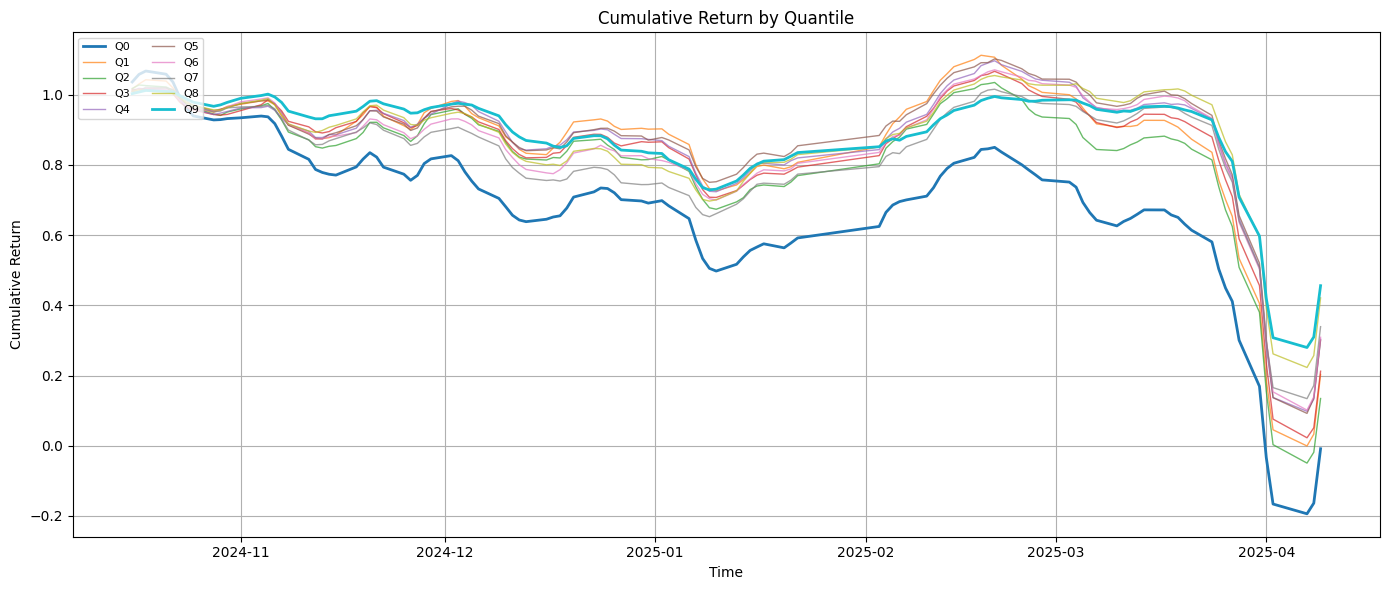

In [74]:
import matplotlib.pyplot as plt

# quantile_cum_list 是一個長度為 num_quantiles 的 list，每個元素是每天的累積報酬序列
# 假設你已經有 quantile_cum_list，可以直接畫圖
num_quantiles = len(quantile_cum_list)

plt.figure(figsize=(14, 6))
for i in range(num_quantiles):
    plt.plot(dates, quantile_cum_list[i], label=f'Q{i}', alpha=0.7 if i not in [0, num_quantiles-1] else 1.0,
             linewidth=2 if i in [0, num_quantiles-1] else 1)

plt.title("Cumulative Return by Quantile")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.legend(loc="upper left", ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()
